In [1]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import tensorflow as tf 
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass 

# !pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
# assert len(tf.config.list_physical_devices('GPU')) > 0

## 1.1 MNIST dataset 

Let's download and load the dataset and display a few random samples from it:

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

Our training set is made up of 28x28 grayscale images of handwritten digits. 

Let's visualize what some of these images and their corresponding training labels look like.

In [3]:
BATCH_SIZE = 64
EPOCHS = 5

In [4]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(24, (3,3), activation=tf.nn.relu), 

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D((2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(36, (3,3), activation=tf.nn.relu),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)
#         '''TODO: Dense layer to output classification probabilities'''
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  115328    
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [18]:
anc.shape

TensorShape([20, 28, 28, 1])

In [58]:
tf.concat([neg, neg], axis=0).shape

TensorShape([64, 28, 28, 1])

In [155]:
# anchor, pos, neg
def get_triplets(images, labels, pair_count=32):
    unique_labels = tf.unique(labels).y
    ancs, poss, negs = [], [], []
    for i, label in enumerate(unique_labels):
        same_label_images = tf.gather_nd(images, tf.where(labels==label))

        mask = tf.logical_not(tf.equal(labels, label))
        other_label_images = tf.boolean_mask(images, mask)

        anc, pos, neg = align_triplets(same_label_images, other_label_images, pair_count=pair_count)
        ancs.append(anc), poss.append(pos), negs.append(neg)
    ancs, poss, negs = tf.convert_to_tensor(ancs), tf.convert_to_tensor(poss), tf.convert_to_tensor(negs)
    ancs = tf.reshape(ancs, (pair_count*(i+1), anc.shape[-3], anc.shape[-2], anc.shape[-1]))
    poss = tf.reshape(poss, (pair_count*(i+1), pos.shape[-3], pos.shape[-2], pos.shape[-1]))
    negs = tf.reshape(negs, (pair_count*(i+1), neg.shape[-3], neg.shape[-2], neg.shape[-1]))
    return ancs, poss, negs

def align_triplets(same_label_images, other_label_images, pair_count=20):
    same_samples_indexes = tf.random.uniform((pair_count,1), minval=0, maxval=same_label_images.shape[0], dtype=tf.dtypes.int32)
    anc = tf.gather_nd(same_label_images, same_samples_indexes)

    same_samples_indexes = tf.random.uniform((pair_count,1), minval=0, maxval=same_label_images.shape[0], dtype=tf.dtypes.int32)
    pos = tf.gather_nd(same_label_images, same_samples_indexes)

    other_samples_indexes = tf.random.uniform((pair_count,1), minval=0, maxval=other_label_images.shape[0], dtype=tf.dtypes.int32)
    neg = tf.gather_nd(other_label_images, other_samples_indexes)
    return anc, pos, neg

# anc, pos, neg = get_triplets(images, labels, pair_count=32)

In [156]:
# Rebuild the CNN model
from IPython.display import clear_output
cnn_model = build_cnn_model()
epochs = 100
batch_size = 64
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # define our optimizer

from sklearn.metrics import accuracy_score

# @tf.function
def grad_stats(grads):
    grad_sum = np.array([(grad.numpy()).sum() for grad in grads])
    zero_grad_count = (grad_sum==0).sum()
    if zero_grad_count>0:
        print(f"'{zero_grad_count}' out of '{grad_sum.shape[0]}' grads are zero")

import time
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
step_counter = 1
epoch_time = 0

In [157]:
for e in range(epochs):
    epoch_start_time = time.time()
    for i, idx in enumerate(range(0, train_images.shape[0], batch_size)):
        step_counter+=1
        (images, labels) = train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size]
        images = tf.convert_to_tensor(images)
        labels = tf.convert_to_tensor(labels)

        anc, pos, neg = get_triplets(images, labels, pair_count=batch_size)
        

        margin=0.5
        with tf.GradientTape() as tape:
            anchor_output = cnn_model(anc)
            positive_output = cnn_model(pos)
            negative_output = cnn_model(neg)

            d_pos = tf.reduce_sum(tf.square(anchor_output - positive_output), 1)
            d_neg = tf.reduce_sum(tf.square(anchor_output - negative_output), 1)

            loss = tf.maximum(0., margin + d_pos - d_neg)
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, cnn_model.trainable_weights)

        optimizer.apply_gradients(zip(grads, cnn_model.trainable_weights))

        if step_counter%10==0:
            print("epoch: {}, step: {}, loss: {}".format(e+1, step_counter, loss))
            print("\t", end="")
            grad_stats(grads)
#             print()
#             break

#     epoch_time = time.time()-epoch_start_time

OperatorNotAllowedInGraphError: in converted code:

    <ipython-input-155-ad4af97edae1>:6 get_triplets  *
        for i, label in enumerate(unique_labels):
    C:\Users\ahsanmemon\.conda\envs\tensorflow2\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:339 for_stmt
        return _py_for_stmt(iter_, extra_test, body, get_state, set_state, init_vars)
    C:\Users\ahsanmemon\.conda\envs\tensorflow2\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:347 _py_for_stmt
        for target in iter_:
    C:\Users\ahsanmemon\.conda\envs\tensorflow2\lib\site-packages\tensorflow_core\python\framework\ops.py:547 __iter__
        self._disallow_iteration()
    C:\Users\ahsanmemon\.conda\envs\tensorflow2\lib\site-packages\tensorflow_core\python\framework\ops.py:540 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    C:\Users\ahsanmemon\.conda\envs\tensorflow2\lib\site-packages\tensorflow_core\python\framework\ops.py:518 _disallow_when_autograph_enabled
        " decorating it directly with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did not convert this function. Try decorating it directly with @tf.function.


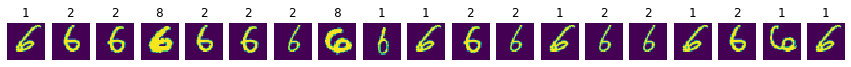

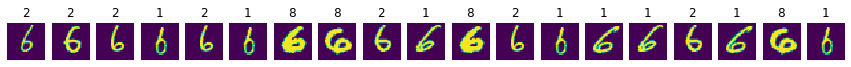

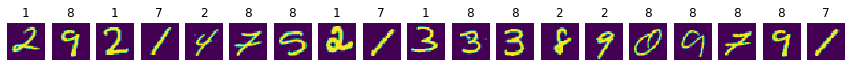

In [11]:
def display_predictions(test_images, cnn_model, n_images = 20):
    start_point = np.random.randint(test_images.shape[0]-n_images)
    my_test_images = test_images[start_point:start_point+n_images]
    predictions = np.argmax(cnn_model(my_test_images), axis=1)
    
    plt.figure(figsize=(15,3))
    for i in range(my_test_images.shape[0]):
        plt.subplot(1, n_images, i+1)
        plt.title(predictions[i])
        plt.imshow(my_test_images[i].reshape(28,28))
        plt.axis("off")
    plt.show()

# display_predictions(test_images, cnn_model, n_images=10)
display_predictions(anc.numpy(), cnn_model, n_images=anc.shape[0]-1)
display_predictions(pos.numpy(), cnn_model, n_images=pos.shape[0]-1)
display_predictions(neg.numpy(), cnn_model, n_images=neg.shape[0]-1)

<b>Visualize Embeddings</b>

C:\Users\ahsanmemon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\ahsanmemon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


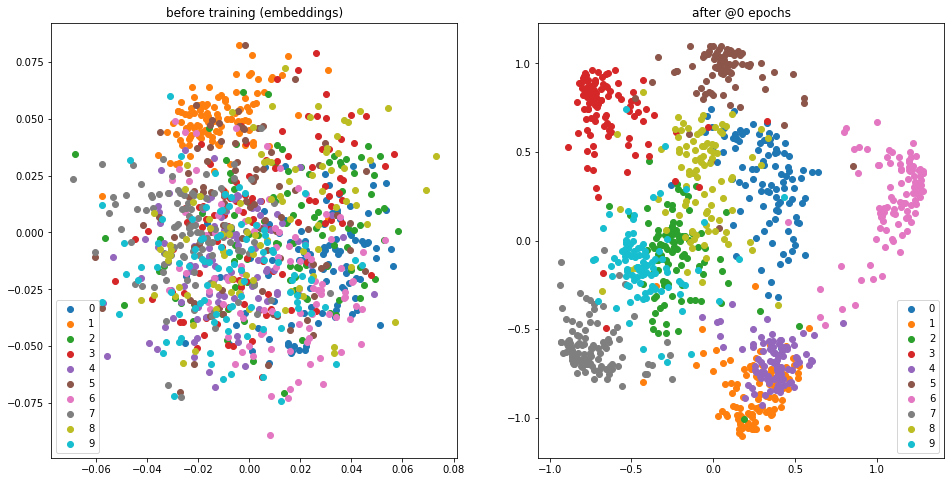

In [154]:
step=10

X_train = train_images[:10000]
y_train = train_labels[:10000]

cnn_model_untrained = build_cnn_model()
embeddings_before_train = cnn_model_untrained(X_train)

embeddings_after_train = cnn_model(X_train)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(embeddings_after_train)
decomposed_gray = pca.fit_transform(embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
test_class_labels = np.unique(np.array(y_train))

for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_train == label]
    decomposed_gray_class = decomposed_gray[y_train == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % e)
    plt.legend()

plt.show()  

In [10]:
# Visualizing the effect of embeddings -> using PCA!
step=10
x_embeddings = testing_embeddings.predict(X_train)
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_train))

pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(x_embeddings)
#     x_test_reshaped = np.reshape(x_test, (len(x_test), 28 * 28))
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_train == label]
    decomposed_gray_class = decomposed_gray[y_train == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()  

NameError: name 'testing_embeddings' is not defined

In [12]:
# # Test the Model
# test_loss, test_acc = cnn_model.evaluate(test_images, test_labels, verbose=0) # TODO
# print('Test accuracy:', test_acc)